In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)
@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

In [3]:
def format_df_to_mlforecast(df, date_col, target_col, unique_id='mean'):
    df_ = df.rename({
        date_col: "ds",
        # target_col: 'y',
    }, axis=1)

    df_['ds'] = pd.to_datetime(df_['ds'])

    df_['y'] = df_[target_col].copy()
    # df_.drop(columns=target_col)

    df_['unique_id'] = unique_id
    return df_

In [4]:
selected_sensors_df = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

In [5]:
scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
        "26M_train":  {"train_start": "2017-04-01", "train_end": "2019-06-01"},
        "24M_train":  {"train_start": "2017-04-01", "train_end": "2019-04-01"},
        "22M_train":  {"train_start": "2017-04-01", "train_end": "2019-02-01"},
        "20M_train":  {"train_start": "2017-04-01", "train_end": "2018-12-01"},
        "18M_train":  {"train_start": "2017-04-01", "train_end": "2018-10-01"},
        "12M_train":  {"train_start": "2017-04-01", "train_end": "2018-04-01"},
        "10M_train":  {"train_start": "2017-04-01", "train_end": "2018-01-25"},
        "8M_train":   {"train_start": "2017-04-01", "train_end": "2017-10-25"},
        
        # Non-Heating Periods
        "NH_3M_train":  {"train_start": "2017-04-15", "train_end": "2017-07-15"},
        "NH_4M_train":  {"train_start": "2017-04-15", "train_end": "2017-08-15"},
        "NH_2M_train":  {"train_start": "2017-04-15", "train_end": "2017-06-15"},
        "NH_1M_train":  {"train_start": "2017-04-15", "train_end": "2017-05-15"},
        "NH_15D_train": {"train_start": "2017-04-15", "train_end": "2017-04-30"},
        "NH_feb_2M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        "NH_feb_1M_train": {"train_start": "2017-02-15", "train_end": "2017-04-15"},
        "NH_mar_2M_train": {"train_start": "2017-03-15", "train_end": "2017-05-15"},
        "NH_mar_1M_train": {"train_start": "2017-03-15", "train_end": "2017-04-15"},

        # Heating Periods
        "H_5M_train":     {"train_start": "2017-06-01", "train_end": "2017-11-01"},
        "H_3M_jul_train": {"train_start": "2017-07-01", "train_end": "2017-10-10"},
        "H_3M_sep_train": {"train_start": "2017-09-01", "train_end": "2017-12-10"},
        "H_3M_nov_train": {"train_start": "2017-11-01", "train_end": "2018-02-10"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

In [6]:
from MLForecastPipeline import *

KeyboardInterrupt: 

In [ ]:
def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on train end date."""
    train_data = df[df[date_col] <= scenario['train_end']]
    test_start = pd.to_datetime(scenario['train_end']) + pd.Timedelta(days=1)
    test_data = df[df[date_col] >= test_start]
    return train_data, test_data

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA, AutoETS, AutoCES, AutoTheta, CrostonClassic, CrostonSBA,
    AutoTBATS, SeasonalExponentialSmoothingOptimized, HoltWinters, Holt,
    SeasonalWindowAverage, ADIDA, CrostonOptimized, IMAPA, TSB,
    MSTL, MFLES, OptimizedTheta, DynamicOptimizedTheta, GARCH
)
models_dict = {
    # "AutoARIMA": AutoARIMA(season_length=365),
    # "AutoETS": AutoETS(season_length=365),
    # "AutoCES": AutoCES(season_length=365),
    # "AutoTheta": AutoTheta(season_length=365),
    # "CrostonClassic": CrostonClassic(),
    # "CrostonSBA": CrostonSBA(),
    # "AutoTBATS": AutoTBATS(season_length=365),
    # "SeasonalExponentialSmoothingOptimized": SeasonalExponentialSmoothingOptimized(season_length=365),
    # "HoltWinters": HoltWinters(season_length=365),
    # "Holt": Holt(),
    # "SeasonalWindowAverage1": SeasonalWindowAverage(season_length=365, window_size=30),
    # "SeasonalWindowAverage2": SeasonalWindowAverage(season_length=365, window_size=60),
    # "SeasonalWindowAverage3": SeasonalWindowAverage(season_length=365, window_size=15),
    # "ADIDA": ADIDA(),
    # "CrostonOptimized": CrostonOptimized(),
    # "IMAPA": IMAPA(),
    # "TSB": TSB(),
    "MSTL_AdditiveB": MSTL(season_length=[7, 30, 365], trend_forecaster=AutoARIMA()),
    "MSTL_Additive": MSTL(season_length=[7, 365], trend_forecaster=AutoARIMA()),
    "MSTL_MultiplicativeB": MSTL(season_length=[7, 30, 365], trend_forecaster=AutoARIMA()),
    "MSTL_Multiplicative": MSTL(season_length=[30, 365], trend_forecaster=AutoARIMA()),
    # "MFLES1": MFLES(season_length=365),
    # "MFLES2": MFLES(season_length=365, fourier_order=3),
    # "OptimizedTheta": OptimizedTheta(season_length=365),
    # "DynamicOptimizedTheta1": DynamicOptimizedTheta(season_length=365),
    # "DynamicOptimizedTheta2": DynamicOptimizedTheta(season_length=365, decomposition_type='additive'),
    # "GARCH": GARCH()
}

class LogTransform:
    def fit_transform(self, y):
        self.min_ = y.data.min()  # ✅ Extract data before calling .min()
        if self.min_ <= 0:
            y = y.data - self.min_ + 1  # Convert GroupedArray to NumPy array
        self.transformed_ = np.log(y)
        return self.transformed_

    def transform(self, y):
        if self.min_ <= 0:
            y = y.data - self.min_ + 1
        return np.log(y)

    def inverse_transform(self, y):
        return np.exp(y) + self.min_ - 1 if self.min_ <= 0 else np.exp(y)



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain, combinations
from sklearn.preprocessing import FunctionTransformer
from mlforecast import MLForecast
from mlforecast.target_transforms import GlobalSklearnTransformer
from statsforecast import StatsForecast

from statsforecast.models import AutoARIMA
from sklearn.base import BaseEstimator, RegressorMixin
import pandas as pd

class StatsForecastWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model=None):
        if model is None:
            self.model = AutoARIMA()
        else:
            self.model = model

    def fit(self, X, y):
        """Fit the StatsForecast model with correctly formatted data."""
        # Extract time index and target values
        df = X.copy()
        df['y'] = y  # Ensure y is in the correct format
        # df = df[['ds', 'y']]  # Only keep necessary columns

        # Convert to the format expected by AutoARIMA
        self.model.fit(df['y'].values)  # Pass only the target series
        return self

    def predict(self, X):
        """Generate forecasts."""
        horizon = len(X)  # Forecast horizon
        forecasts = self.model.predict(horizon)
        return pd.DataFrame(forecasts).iloc[:, 0].values  # Extract forecast values

    def get_params(self, deep=True):
        """Return model parameters."""
        return {}

    def set_params(self, **params):
        """Set model parameters."""
        return self


# Wrap the StatsForecast models
wrapped_models_dict = {name: StatsForecastWrapper(model) for name, model in models_dict.items()}

def evaluate_models_statsforecast(train_df, test_df, target_transforms):
    results = []
    
    # Define Log Transformation
    log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
    global_log_transformer = GlobalSklearnTransformer(log_transformer)
    
    # Append Log Transformation to target transforms
    target_transforms.append(global_log_transformer)
    
    valid_transform_combinations = [()] + list(chain(combinations(target_transforms, 1), combinations(target_transforms, 2)))
    valid_transform_combinations = [tc for tc in valid_transform_combinations if filter_conflicting_transforms(tc)]
    max_test_length = len(test_df)
    test_lengths = [t for t in range(30, 181, 30)] + [240, 300, 360, 480, 600, 720, max_test_length]
    test_lengths = [t for t in test_lengths if t <= max_test_length]
    total_fits = len(valid_transform_combinations) * len(models_dict)
    print(f"Total model fits to run: {total_fits}")
    fit_num = 0

    for model_name, model in models_dict.items():
        for transform_combination in valid_transform_combinations:
            print(f"{fit_num + 1}/{total_fits} Training {model_name} with transforms: {stringify_transform(list(transform_combination))}...")
        # try:
            fcst = MLForecast(
                models=[wrapped_models_dict[model_name]],
                target_transforms=list(transform_combination),
                freq='D',  # Assuming daily frequency, adjust if needed
                lags=[]  # No lags since using StatsForecast models
            )
            print(train_df)
            
            fcst.fit(train_df)
            predictions = fcst.predict(h=max_test_length)
            print(predictions)
                
            test_df_copy = test_df.copy()
            test_df_copy['forecast'] = predictions['StatsForecastWrapper'].values 
            
            test_df_copy.plot(x='ds', y=['y', 'forecast'], title=f"Forecast vs Actuals for {model_name} with {stringify_transform(list(transform_combination))}")
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.show()
            
            error_dict = {}
            for test_length in test_lengths:
                eval_subset = test_df_copy.iloc[:test_length]
                error_dict[f"test_{test_length}_days"] = mape_met(eval_subset['y'].values, eval_subset['forecast'].values)
            
            results.append({
                "Model": model_name,
                "Transforms": stringify_transform(list(transform_combination)),
                **error_dict
            })
            print(f"{model_name} MAPE: {error_dict[f'test_{max_test_length}_days']:.2f}% with transforms {stringify_transform(list(transform_combination))}")
            # except Exception as e:
                # print(f"Skipping combination {fit_num + 1} due to error: {e}")
            fit_num += 1

    return pd.DataFrame(results)


Total model fits to run: 598
1/598 Training AutoARIMA with transforms: ...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.848111
1           2 2019-04-03             47.848111
2           2 2019-04-04             47.848111
3           2 2019-04-05             47.848111
4           2 2019-04-06             47.848111
..        ...        ...                   ...
550         2 2020-10-03             47.848111
551         2 2020-10-04             47.848111
552         2 2020-10-05             47.848111

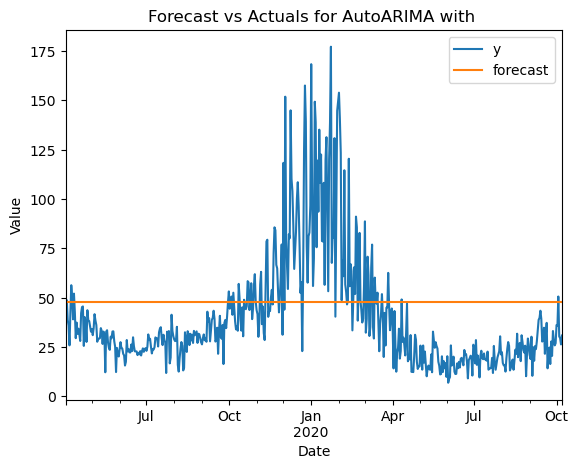

AutoARIMA MAPE: 86.85% with transforms 
2/598 Training AutoARIMA with transforms: AutoDifferences(max_diffs=370)...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.820183
1           2 2019-04-03             54.265996
2           2 2019-04-04             60.711809
3           2 2019-04-05             67.157623
4           2 2019-04-06             73.603436
..        ...        ...                   ...
550         2 2020-10-03           3593.017397
551         2 2020-10-04           3599.463210
552  

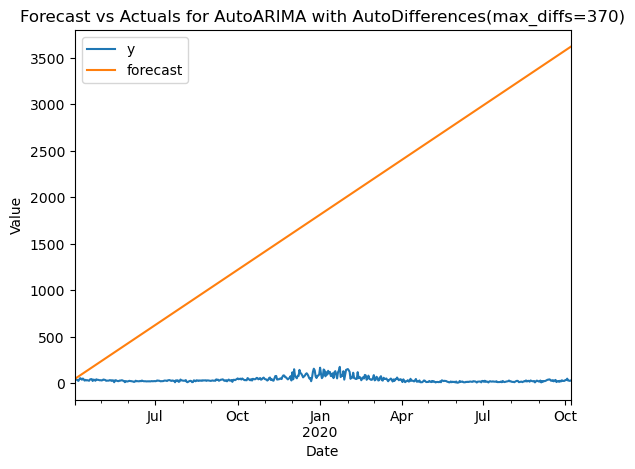

AutoARIMA MAPE: 7108.38% with transforms AutoDifferences(max_diffs=370)
3/598 Training AutoARIMA with transforms: AutoSeasonalDifferences(max_diffs=370, n_seasons=10, season_length=247)...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.848111
1           2 2019-04-03             47.848111
2           2 2019-04-04             47.848111
3           2 2019-04-05             47.848111
4           2 2019-04-06             47.848111
..        ...        ...                   ...
550         2 2020-10-03  

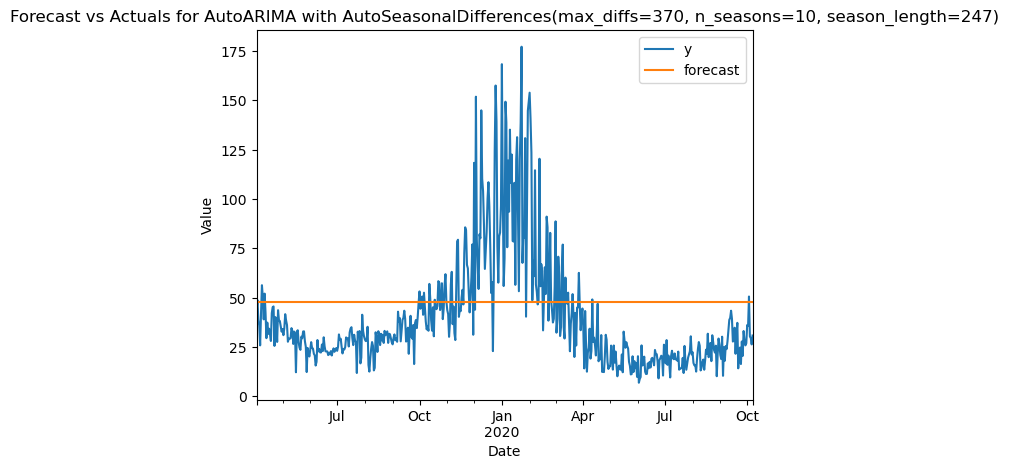

AutoARIMA MAPE: 86.85% with transforms AutoSeasonalDifferences(max_diffs=370, n_seasons=10, season_length=247)
4/598 Training AutoARIMA with transforms: AutoSeasonalityAndDifferences(max_diffs=370, max_season_length=247, n_seasons=10)...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.848111
1           2 2019-04-03             47.848111
2           2 2019-04-04             47.848111
3           2 2019-04-05             47.848111
4           2 2019-04-06             47.848111
..        ...        ...

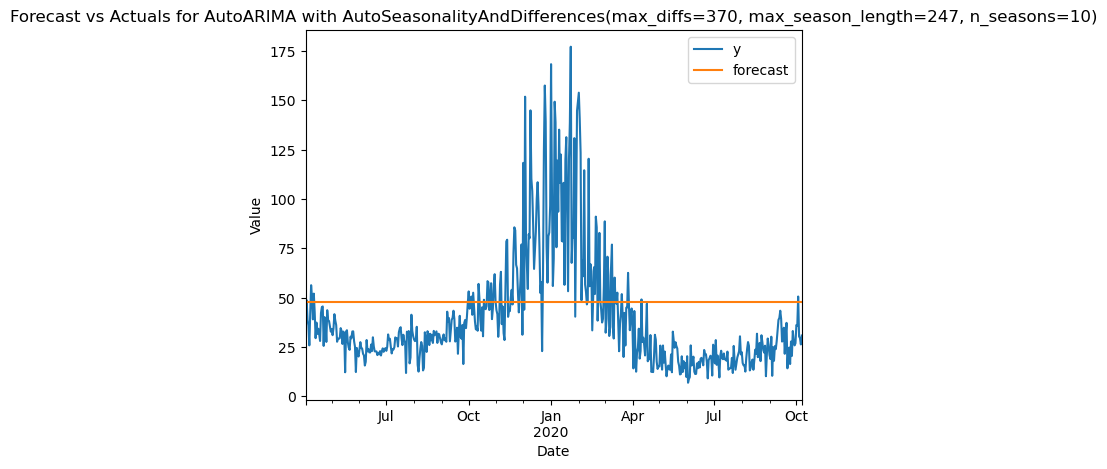

AutoARIMA MAPE: 86.85% with transforms AutoSeasonalityAndDifferences(max_diffs=370, max_season_length=247, n_seasons=10)
5/598 Training AutoARIMA with transforms: LocalStandardScaler()...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.813149
1           2 2019-04-03             47.813149
2           2 2019-04-04             47.813149
3           2 2019-04-05             47.813149
4           2 2019-04-06             47.813149
..        ...        ...                   ...
550         2 2020-10-03   

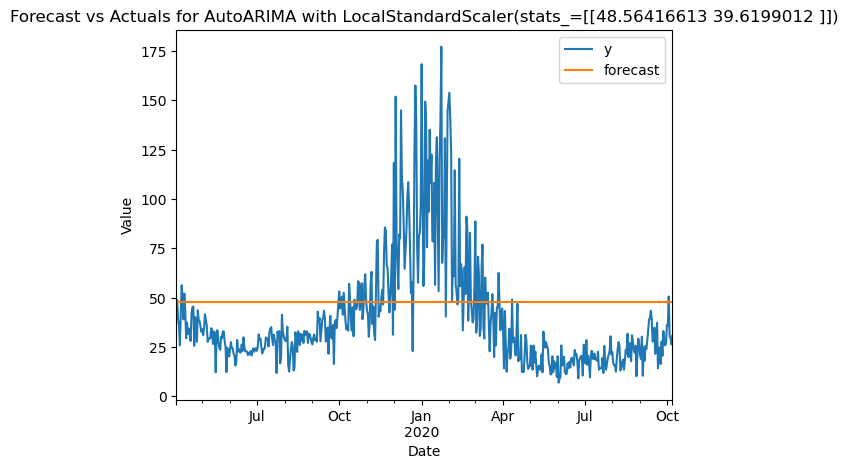

AutoARIMA MAPE: 86.75% with transforms LocalStandardScaler(stats_=[[48.56416613 39.6199012 ]])
6/598 Training AutoARIMA with transforms: LocalMinMaxScaler()...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.848111
1           2 2019-04-03             47.848111
2           2 2019-04-04             47.848111
3           2 2019-04-05             47.848111
4           2 2019-04-06             47.848111
..        ...        ...                   ...
550         2 2020-10-03             47.848111
551     

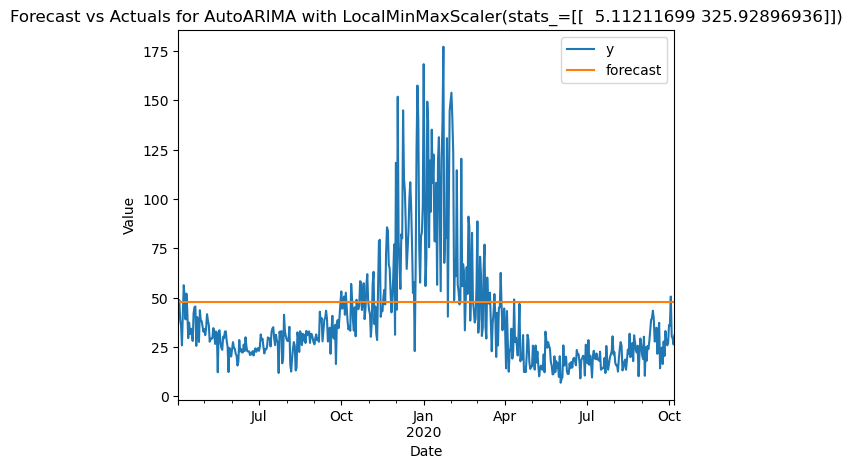

AutoARIMA MAPE: 86.85% with transforms LocalMinMaxScaler(stats_=[[  5.11211699 325.92896936]])
7/598 Training AutoARIMA with transforms: LocalBoxCox()...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             45.571254
1           2 2019-04-03             45.571254
2           2 2019-04-04             45.571254
3           2 2019-04-05             45.571254
4           2 2019-04-06             45.571254
..        ...        ...                   ...
550         2 2020-10-03             45.571254
551         2 

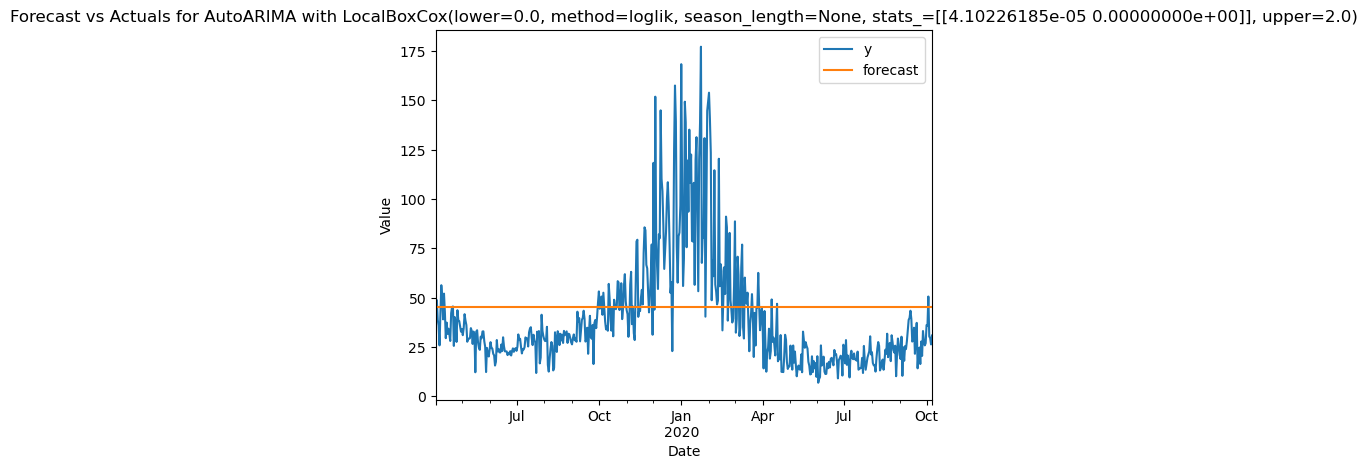

AutoARIMA MAPE: 80.22% with transforms LocalBoxCox(lower=0.0, method=loglik, season_length=None, stats_=[[4.10226185e-05 0.00000000e+00]], upper=2.0)
8/598 Training AutoARIMA with transforms: GlobalSklearnTransformer()...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             45.571461
1           2 2019-04-03             45.571461
2           2 2019-04-04             45.571461
3           2 2019-04-05             45.571461
4           2 2019-04-06             45.571461
..        ...        ...                

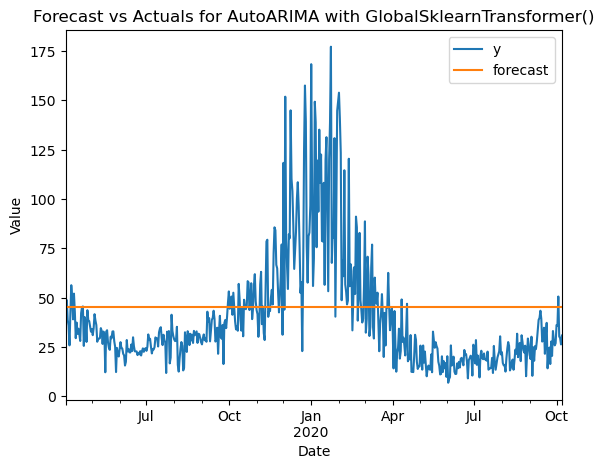

AutoARIMA MAPE: 80.22% with transforms GlobalSklearnTransformer()
9/598 Training AutoARIMA with transforms: AutoDifferences(max_diffs=370) | LocalStandardScaler(stats_=[[48.56416613 39.6199012 ]])...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             47.825468
1           2 2019-04-03             54.276565
2           2 2019-04-04             60.727662
3           2 2019-04-05             67.178760
4           2 2019-04-06             73.629857
..        ...        ...                   ...
550         2 2

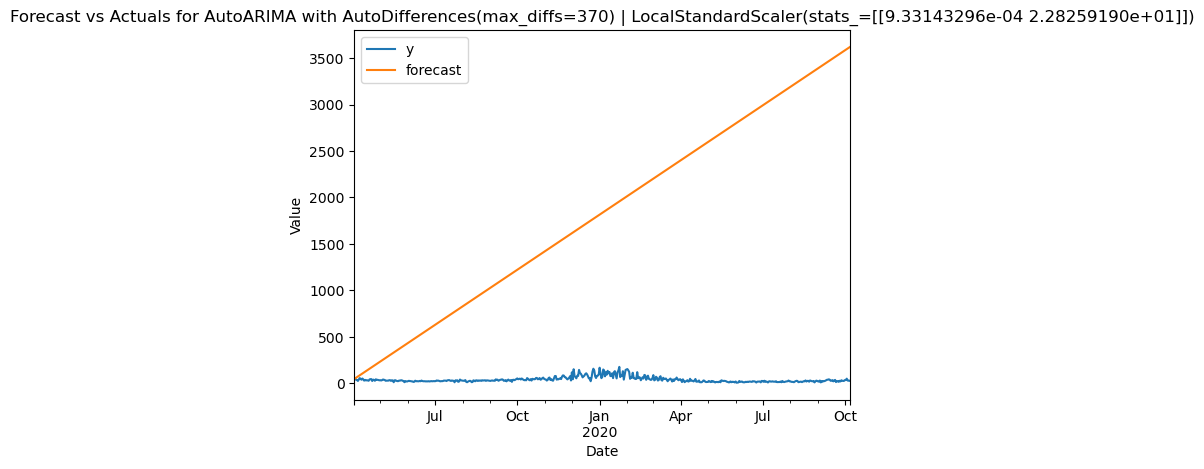

AutoARIMA MAPE: 7114.16% with transforms AutoDifferences(max_diffs=370) | LocalStandardScaler(stats_=[[9.33143296e-04 2.28259190e+01]])
10/598 Training AutoARIMA with transforms: AutoDifferences(max_diffs=370) | LocalMinMaxScaler(stats_=[[  5.11211699 325.92896936]])...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]
    unique_id         ds  StatsForecastWrapper
0           2 2019-04-02             41.369190
1           2 2019-04-03             41.364009
2           2 2019-04-04             41.358828
3           2 2019-04-05             41.353648
4           2 2019-04-06             4

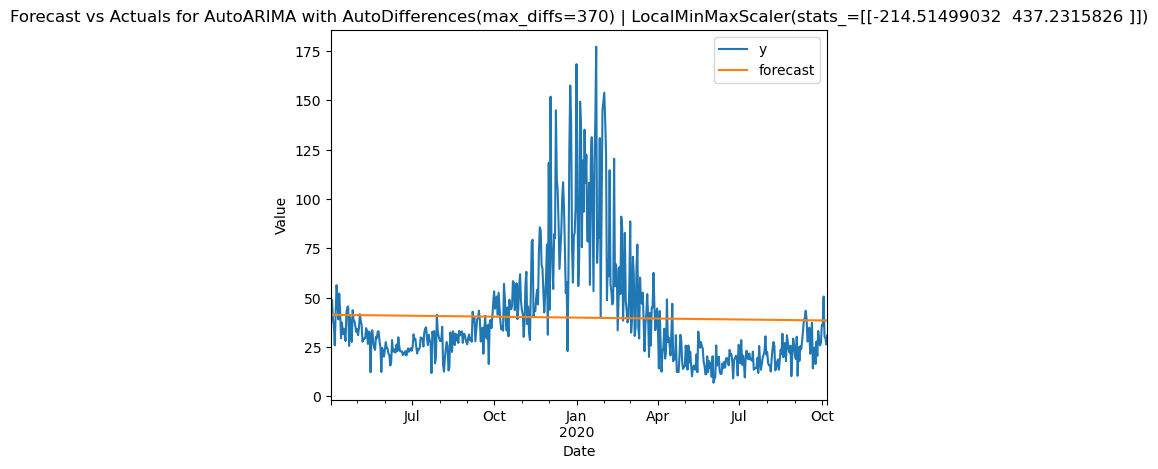

AutoARIMA MAPE: 64.36% with transforms AutoDifferences(max_diffs=370) | LocalMinMaxScaler(stats_=[[-214.51499032  437.2315826 ]])
11/598 Training AutoARIMA with transforms: AutoDifferences(max_diffs=370) | LocalBoxCox(lower=0.0, method=loglik, season_length=None, stats_=[[4.10226185e-05 0.00000000e+00]], upper=2.0)...
            ds          y unique_id
0   2017-03-22  40.683844         2
1   2017-03-23  29.237465         2
2   2017-03-24  43.675636         2
3   2017-03-25  58.792217         2
4   2017-03-26  48.348401         2
..         ...        ...       ...
736 2019-03-28  56.822826         2
737 2019-03-29  41.556522         2
738 2019-03-30  39.097701         2
739 2019-03-31  40.261603         2
740 2019-04-01  41.374370         2

[741 rows x 3 columns]


ValueError: All values in data must be positive for method='loglik'

In [ ]:
sensor_name = "2"
scenario = scenarios_sensors['2']['24M_train']

formatted_df = format_df_to_mlforecast(selected_sensors_df[['full_date', sensor_name]], 'full_date', sensor_name, unique_id=sensor_name)
formatted_df = formatted_df[['ds', 'y', 'unique_id']]

train_df, test_df = split_data(formatted_df, scenario)
target_transforms = get_dynamic_transforms(train_df)

results = evaluate_models_statsforecast(train_df, test_df, target_transforms)

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
import time

def process_scenario(sensor_name, scenario_name, scenario, selected_sensors_df):
    """ Process each scenario independently and save results. """
    print(f'{sensor_name}_{scenario_name}')
    formatted_df = format_df_to_mlforecast(selected_sensors_df[['full_date', sensor_name]], 'full_date', sensor_name, unique_id=sensor_name)
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]
    
    train_df, test_df = split_data(formatted_df, scenario)
    target_transforms = get_dynamic_transforms(train_df)

    results = evaluate_models_statsforecast(train_df, test_df, target_transforms)

    save_results(results, f"results/run_5/{sensor_name}_{scenario_name}.csv")

    return results

def run_all_scenarios_parallel(scenarios_sensors, selected_sensors_df):
    # don't use all cpus (instead all but one)
    n_jobs = max(1, multiprocessing.cpu_count() - 1)
    results = Parallel(n_jobs=n_jobs)( 
        delayed(process_scenario)(sensor_name, scenario_name, scenario, selected_sensors_df )
        for sensor_name, scenarios in scenarios_sensors.items()
        for scenario_name, scenario in scenarios.items()
    )

    return results


In [ ]:
results = run_all_scenarios_parallel(scenarios_sensors, selected_sensors_df)